In [ ]:
# Download CIFAR-10 dataset
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz


--2026-01-22 17:24:46--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  73.5MB/s    in 2.2s    

2026-01-22 17:24:49 (73.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
# Extract the dataset
!tar -xvzf cifar-10-python.tar.gz


cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
# List extracted files
import os

os.listdir("cifar-10-batches-py")


['data_batch_5',
 'readme.html',
 'data_batch_1',
 'data_batch_3',
 'data_batch_4',
 'batches.meta',
 'test_batch',
 'data_batch_2']

In [ ]:
import numpy as np
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b'data'], np.array(dict[b'labels'])

X_train_list, y_train_list = [], []
for i in range(1, 6):
    X_batch, y_batch = load_cifar_batch(f'cifar-10-batches-py/data_batch_{i}')
    X_train_list.append(X_batch)
    y_train_list.append(y_batch)

X_train = np.concatenate(X_train_list).astype("float32") / 255.0
y_train = np.concatenate(y_train_list)

X_test, y_test = load_cifar_batch('cifar-10-batches-py/test_batch')
X_test = X_test.astype("float32") / 255.0

X_train_small = X_train[:5000]
y_train_small = y_train[:5000]
X_test_small = X_test[:500]
y_test_small = y_test[:500]

print(f"Full Training shape: {X_train.shape}")
print(f"Small Training shape: {X_train_small.shape}")
print(f"Small Test shape: {X_test_small.shape}")

Full Training shape: (50000, 3072)
Small Training shape: (5000, 3072)
Small Test shape: (500, 3072)


In [ ]:
with open("cifar-10-batches-py/batches.meta", 'rb') as f:
    meta = pickle.load(f, encoding='bytes')

class_names = meta[b'label_names']
print(class_names)


[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


In [ ]:
class DistanceMetrics:
    @staticmethod
    def euclidean(x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2, axis=1))

    @staticmethod
    def manhattan(x1, x2):
        return np.sum(np.abs(x1 - x2), axis=1)

    @staticmethod
    def minkowski(x1, x2, p=3):
        return np.sum(np.abs(x1 - x2)**p, axis=1)**(1/p)

    @staticmethod
    def cosine_similarity(x1, x2):
        dot_product = np.dot(x1, x2)
        norm_a = np.linalg.norm(x1, axis=1)
        norm_b = np.linalg.norm(x2)
        similarity = dot_product / (norm_a * norm_b + 1e-8)

        return 1 - similarity

    @staticmethod
    def hamming(x1, x2):
        return np.sum(x1 != x2, axis=1) / x1.shape[1]

In [ ]:
from collections import Counter

class KNNClassifier:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric
        self.metrics = DistanceMetrics()

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _get_distance(self, x_test_row):
        if self.distance_metric == 'euclidean':
            return self.metrics.euclidean(self.X_train, x_test_row)
        elif self.distance_metric == 'manhattan':
            return self.metrics.manhattan(self.X_train, x_test_row)
        elif self.distance_metric == 'minkowski':
            return self.metrics.minkowski(self.X_train, x_test_row)
        elif self.distance_metric == 'cosine':
            return self.metrics.cosine_similarity(self.X_train, x_test_row)
        elif self.distance_metric == 'hamming':
            return self.metrics.hamming(self.X_train, x_test_row)
        else:
            raise ValueError("Unknown distance metric")

    def predict(self, X_test):
        predictions = []
        for i in range(len(X_test)):
            distances = self._get_distance(X_test[i])

            k_indices = np.argsort(distances)[:self.k]

            k_nearest_labels = [self.y_train[idx] for idx in k_indices]

            most_common = Counter(k_nearest_labels).most_common(1)
            predictions.append(most_common[0][0])

            if (i + 1) % 100 == 0:
                print(f"Predicted {i + 1}/{len(X_test)} samples...")

        return np.array(predictions)

In [ ]:
def get_metrics(y_true, y_pred, num_classes=10):
    accuracy = np.sum(y_true == y_pred) / len(y_true)

    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        conf_matrix[t, p] += 1

    precision = []
    recall = []
    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = np.sum(conf_matrix[:, i]) - tp
        fn = np.sum(conf_matrix[i, :]) - tp

        precision.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
        recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

    return accuracy, conf_matrix, np.array(precision), np.array(recall)

In [ ]:
k_values = [3, 4, 9, 20, 47]
metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'hamming']

results = {metric: [] for metric in metrics}
best_accuracy = -1
best_config = None

for metric in metrics:
    print(f"\n--- Testing Metric: {metric} ---")
    for k in k_values:
        knn = KNNClassifier(k=k, distance_metric=metric)
        knn.fit(X_train_small, y_train_small)

        y_pred = knn.predict(X_test_small)

        acc, _, _, _ = get_metrics(y_test_small, y_pred)
        results[metric].append(acc)

        print(f"K={k} | Accuracy: {acc:.4f}")

        if acc > best_accuracy:
            best_accuracy = acc
            best_config = (k, metric)

print(f"\nBEST MODEL: K={best_config[0]}, Metric={best_config[1]} with Accuracy={best_accuracy}")


--- Testing Metric: euclidean ---
Predicted 100/500 samples...
Predicted 200/500 samples...
Predicted 300/500 samples...
Predicted 400/500 samples...
Predicted 500/500 samples...
K=3 | Accuracy: 0.2800
Predicted 100/500 samples...
Predicted 200/500 samples...
Predicted 300/500 samples...
Predicted 400/500 samples...
Predicted 500/500 samples...
K=4 | Accuracy: 0.2840
Predicted 100/500 samples...
Predicted 200/500 samples...
Predicted 300/500 samples...
Predicted 400/500 samples...
Predicted 500/500 samples...
K=9 | Accuracy: 0.2900
Predicted 100/500 samples...
Predicted 200/500 samples...
Predicted 300/500 samples...
Predicted 400/500 samples...
Predicted 500/500 samples...
K=20 | Accuracy: 0.2660
Predicted 100/500 samples...
Predicted 200/500 samples...
Predicted 300/500 samples...
Predicted 400/500 samples...
Predicted 500/500 samples...
K=47 | Accuracy: 0.2520

--- Testing Metric: manhattan ---
Predicted 100/500 samples...
Predicted 200/500 samples...
Predicted 300/500 samples...
P

--- BEST MODEL SELECTION ---
Best K-Value: 4
Best Distance Metric: manhattan
Highest Testing Accuracy: 0.3080

Predicted 100/500 samples...
Predicted 200/500 samples...
Predicted 300/500 samples...
Predicted 400/500 samples...
Predicted 500/500 samples...
--- DETAILED METRICS FOR BEST MODEL ---
Confusion Matrix:
 [[25  0  6  1  6  0  2  2 13  2]
 [ 4  9  4  3  8  0  3  0  8  2]
 [ 8  0 21  3  9  4  4  0  2  0]
 [ 2  0 10 10  9  8  8  0  2  0]
 [ 3  0 10  2 14  1  5  0  4  1]
 [ 6  0 11  4 12  8  5  1  1  0]
 [ 1  1 15  4 19  0 12  0  2  0]
 [ 1  1  8  7 12  3  3  8  3  1]
 [ 8  3  3  1  5  1  0  0 35  1]
 [ 5  2  6  4  7  0  2  3 15 12]]

Precision per class (0-9): [0.4  0.56 0.22 0.26 0.14 0.32 0.27 0.57 0.41 0.63]
Recall per class (0-9): [0.44 0.22 0.41 0.2  0.35 0.17 0.22 0.17 0.61 0.21]


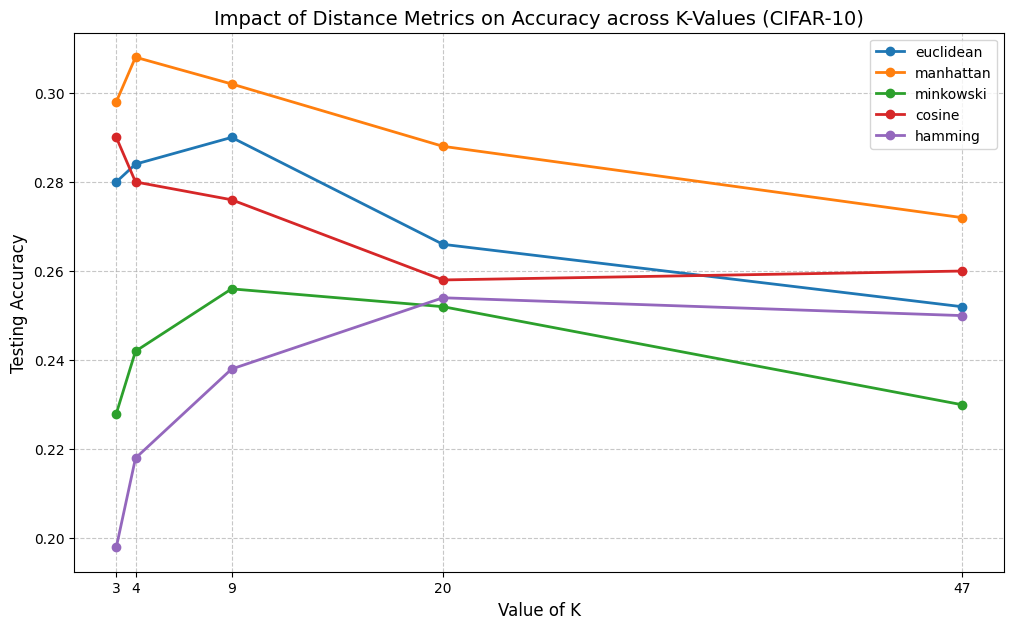

In [ ]:
import matplotlib.pyplot as plt

best_idx = np.argmax([max(results[m]) for m in metrics])
best_metric_name = metrics[best_idx]
best_k_idx = np.argmax(results[best_metric_name])
best_k_val = k_values[best_k_idx]
final_best_acc = results[best_metric_name][best_k_idx]

print(f"--- BEST MODEL SELECTION ---")
print(f"Best K-Value: {best_k_val}")
print(f"Best Distance Metric: {best_metric_name}")
print(f"Highest Testing Accuracy: {final_best_acc:.4f}\n")

knn_final = KNNClassifier(k=best_k_val, distance_metric=best_metric_name)
knn_final.fit(X_train_small, y_train_small)
y_pred_final = knn_final.predict(X_test_small)

acc, conf_matrix, precisions, recalls = get_metrics(y_test_small, y_pred_final)

print(f"--- DETAILED METRICS FOR BEST MODEL ---")
print("Confusion Matrix:\n", conf_matrix)
print("\nPrecision per class (0-9):", np.round(precisions, 2))
print("Recall per class (0-9):", np.round(recalls, 2))

plt.figure(figsize=(12, 7))
for metric in metrics:
    plt.plot(k_values, results[metric], marker='o', linestyle='-', linewidth=2, label=metric)

plt.title("Impact of Distance Metrics on Accuracy across K-Values (CIFAR-10)", fontsize=14)
plt.xlabel("Value of K", fontsize=12)
plt.ylabel("Testing Accuracy", fontsize=12)
plt.xticks(k_values)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()